In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import copy
import os
import platform
%matplotlib inline

In [2]:
class SoftmaxClassifier:
    
    def __init__(self,dictionary):
        self.X_train = list()
        self.y_train = list() 
        self.X_test  = list()
        self.y_test  = list()
        self.X_train_x = list()
        self.y_train_x = list()
        self.data_dir = dictionary['data_dir']
        self.lr=dictionary['learning_rate']
        self.initial_lr=dictionary['learning_rate']
        self.num_iters=dictionary['num_iters']
        self.batch_size=dictionary['batch_size']
        self.save_weights=dictionary['save_weights']
        self.reg=1e-3
        
        if dictionary['load_weights'] == 1:
            with open('./save/weights' , 'rb') as f:
                self.W = pickle.load(f)
        else:
            # Random initialization of W
            C, D = 10, 3073  # C :number of classes, D: dimension of each flattened image
            self.W = np.random.randn(C, D) * 0.01

    def load_pickle(self, f):
        version = platform.python_version_tuple()
        if version[0] == '2':
            return  pickle.load(f)
        elif version[0] == '3':
            return  pickle.load(f, encoding='latin1')
        raise ValueError("invalid python version: {}".format(version))

    def load_CIFAR_batch(self, filename):
        with open(filename, 'rb') as f:
            datadict = self.load_pickle(f)
            X = datadict['data']
            Y = datadict['labels']
            X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
            Y = np.array(Y)
            return X, Y

    def load_CIFAR10(self, ROOT):
        xs = []
        ys = []
        for b in range(1,6):
            f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
            X, Y = self.load_CIFAR_batch(f)
            xs.append(X)
            ys.append(Y)    
        Xtr = np.concatenate(xs)
        Ytr = np.concatenate(ys)
        del X, Y
        Xte, Yte = self.load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
        return Xtr/255.0, Ytr, Xte/255.0, Yte
    
    def loadData(self):
        
        self.X_train, self.y_train, self.X_test, self.y_test = self.load_CIFAR10(self.data_dir)
        
        print('Training data shape: ', self.X_train.shape)
        print('Training labels shape: ', self.y_train.shape)
        print('Test data shape: ', self.X_test.shape)
        print('Test labels shape: ', self.y_test.shape)
        
    def visualize(self):
        classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
        num_classes = len(classes)
        samples_per_class = 7
        for y, cls in enumerate(classes):
            idxs = np.flatnonzero(self.y_train == y)
            idxs = np.random.choice(idxs, samples_per_class, replace=False)
            for i, idx in enumerate(idxs):
                plt_idx = i * num_classes + y + 1
                plt.subplot(samples_per_class, num_classes, plt_idx)
                plt.imshow(self.X_train[idx])
                plt.axis('off')
                if i == 0:
                    plt.title(cls)
        plt.show()
    
    def conver_to_onehot(self, label):
        
        OneHot = np.zeros((label.shape[0],10))
        for i in range(label.shape[0]):

            OneHot[i,label[i]] = 1

        return OneHot
    
    def getData(self):
        
        num_training = 50000
        mask = list(range(num_training))
        X_train = np.copy(self.X_train[mask])
        y_train = np.copy(self.y_train[mask])

        num_test = 10000
        mask = list(range(num_test))
        X_test = np.copy(self.X_test[mask])
        y_test = np.copy(self.y_test[mask])

        X_train = np.reshape(X_train, (X_train.shape[0], -1))
        X_test = np.reshape(X_test, (X_test.shape[0], -1))
        
        y_train = self.conver_to_onehot(y_train)
        y_test = self.conver_to_onehot(y_test)
        
        return X_train, X_test, y_train, y_test

    def train(self, x, y):

        N,_ = x.shape  # N is the sample size
        chunk = int((N/self.batch_size)+0.5)
        # Train the model using mini-batch stochastic gradient descent.
        loss_record = [float('inf')]
        count = 0
        for it in range(self.num_iters):
            # Randomly chosen mini-batch
            indices = np.random.choice(N, N, replace=False)
            idx=[]
            k = 0
            loss = 0
            for m in range(chunk):
                idx.append(indices[k:k+self.batch_size])
                k = k + self.batch_size
            
            for b in range(chunk):
                
                x_batch = x[idx[b], :]
                y_batch = y[idx[b]]

                one = np.ones((x_batch.shape[0], 1))
                x_batch = np.append(one, x_batch, axis=1)

                # Calculate loss and gradient for the iteration
                batch_loss, grad = self.cross_entropy_loss(x_batch, y_batch, self.reg)
                loss = loss + batch_loss
#                 print('Iteration = %d, batch = %d, loss =%f'% (it, b+1, batch_loss))

                # Update W
                self.W -= self.lr * grad
        
            #Adaptive learning rate
            #self.lr = self.initial_lr * 1/(1 + 0.0001 * it)
                
                
            loss_record.append(loss)
            print('Iteration = %d, loss =%f'% (it, loss))
            
            if self.save_weights == 1 and (it+1)%100 ==0:
                with open('./save/weights', 'wb') as files:
                    pickle.dump(self.W, files)
            
            #Early stoping criteria
            if abs(loss_record[-2] - loss_record[-1]) < 1e-6:
                count = count + 1
            else:
                count = 0
                
            if count == 10:
                break
            
        return loss_record

    def predict(self, x):
       
        one = np.ones((x.shape[0], 1))
        x = np.append(one, x, axis=1)
        y = self.W.dot(x.T)
        y_pred = np.argmax(y, axis=0)
        return y_pred
    
    def test(self, x, y):
        
        pred = self.predict(x)
        
        count = 0
        for i in range(len(pred)):
            
            if np.argmax(y[i]) == pred[i]:
                count += 1
        
        print('Correct calssification = %d/%d, Accuracy = %f'% (count, len(pred), count/len(pred)))      

    def cross_entropy_loss(self, x, y, reg):
       
        # Calculation of loss
        z = np.dot(self.W, x.T)
        z -= np.max(z, axis=0)  # Max trick for the softmax, preventing infinite values
        p = np.exp(z) / np.sum(np.exp(z), axis=0)  # Softmax function
        L = -1 / y.shape[0] * np.sum(np.log(p.T[range(y.shape[0]),y.argmax(axis=1)]))  # Cross-entropy loss
        R = 0.5 * np.sum(np.multiply(self.W, self.W))  # Regularization term
        loss = L + R * self.reg  # Total loss

        # Calculation of dW
        p.T[range(y.shape[0]),y.argmax(axis=1)] -= 1
        dW = 1 / len(y) * p.dot(x) + self.reg * self.W
        return loss, dW
   

In [3]:
dictionary = {'learning_rate' : 1e-3,
             'num_iters' : 1000,
              'batch_size': 50000,
              'save_weights': 1,
              'load_weights': 1,
             'data_dir' : './data/cifar-10-batches-py'}

In [4]:
classifier = SoftmaxClassifier(dictionary)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


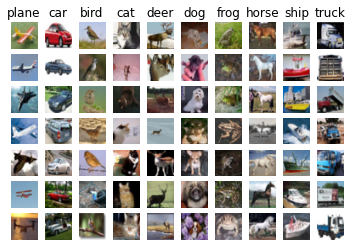

In [5]:
classifier.loadData()
classifier.visualize()

In [6]:
X_train, X_test, y_train, y_test = classifier.getData()

In [7]:
loss = classifier.train(X_train, y_train)

Iteration = 0, loss =1.685484
Iteration = 1, loss =1.685482
Iteration = 2, loss =1.685480
Iteration = 3, loss =1.685478
Iteration = 4, loss =1.685475
Iteration = 5, loss =1.685473
Iteration = 6, loss =1.685471
Iteration = 7, loss =1.685469
Iteration = 8, loss =1.685467
Iteration = 9, loss =1.685464
Iteration = 10, loss =1.685462
Iteration = 11, loss =1.685460
Iteration = 12, loss =1.685458
Iteration = 13, loss =1.685456
Iteration = 14, loss =1.685454
Iteration = 15, loss =1.685451
Iteration = 16, loss =1.685449
Iteration = 17, loss =1.685447
Iteration = 18, loss =1.685445
Iteration = 19, loss =1.685443
Iteration = 20, loss =1.685440
Iteration = 21, loss =1.685438
Iteration = 22, loss =1.685436
Iteration = 23, loss =1.685434
Iteration = 24, loss =1.685432
Iteration = 25, loss =1.685430
Iteration = 26, loss =1.685427
Iteration = 27, loss =1.685425
Iteration = 28, loss =1.685423
Iteration = 29, loss =1.685421
Iteration = 30, loss =1.685419
Iteration = 31, loss =1.685417
Iteration = 32, lo

Iteration = 260, loss =1.684924
Iteration = 261, loss =1.684922
Iteration = 262, loss =1.684920
Iteration = 263, loss =1.684918
Iteration = 264, loss =1.684916
Iteration = 265, loss =1.684913
Iteration = 266, loss =1.684911
Iteration = 267, loss =1.684909
Iteration = 268, loss =1.684907
Iteration = 269, loss =1.684905
Iteration = 270, loss =1.684903
Iteration = 271, loss =1.684901
Iteration = 272, loss =1.684899
Iteration = 273, loss =1.684896
Iteration = 274, loss =1.684894
Iteration = 275, loss =1.684892
Iteration = 276, loss =1.684890
Iteration = 277, loss =1.684888
Iteration = 278, loss =1.684886
Iteration = 279, loss =1.684884
Iteration = 280, loss =1.684882
Iteration = 281, loss =1.684879
Iteration = 282, loss =1.684877
Iteration = 283, loss =1.684875
Iteration = 284, loss =1.684873
Iteration = 285, loss =1.684871
Iteration = 286, loss =1.684869
Iteration = 287, loss =1.684867
Iteration = 288, loss =1.684865
Iteration = 289, loss =1.684862
Iteration = 290, loss =1.684860
Iteratio

Iteration = 517, loss =1.684385
Iteration = 518, loss =1.684382
Iteration = 519, loss =1.684380
Iteration = 520, loss =1.684378
Iteration = 521, loss =1.684376
Iteration = 522, loss =1.684374
Iteration = 523, loss =1.684372
Iteration = 524, loss =1.684370
Iteration = 525, loss =1.684368
Iteration = 526, loss =1.684366
Iteration = 527, loss =1.684364
Iteration = 528, loss =1.684362
Iteration = 529, loss =1.684360
Iteration = 530, loss =1.684358
Iteration = 531, loss =1.684356
Iteration = 532, loss =1.684353
Iteration = 533, loss =1.684351
Iteration = 534, loss =1.684349
Iteration = 535, loss =1.684347
Iteration = 536, loss =1.684345
Iteration = 537, loss =1.684343
Iteration = 538, loss =1.684341
Iteration = 539, loss =1.684339
Iteration = 540, loss =1.684337
Iteration = 541, loss =1.684335
Iteration = 542, loss =1.684333
Iteration = 543, loss =1.684331
Iteration = 544, loss =1.684329
Iteration = 545, loss =1.684327
Iteration = 546, loss =1.684325
Iteration = 547, loss =1.684322
Iteratio

Iteration = 774, loss =1.683859
Iteration = 775, loss =1.683857
Iteration = 776, loss =1.683855
Iteration = 777, loss =1.683852
Iteration = 778, loss =1.683850
Iteration = 779, loss =1.683848
Iteration = 780, loss =1.683846
Iteration = 781, loss =1.683844
Iteration = 782, loss =1.683842
Iteration = 783, loss =1.683840
Iteration = 784, loss =1.683838
Iteration = 785, loss =1.683836
Iteration = 786, loss =1.683834
Iteration = 787, loss =1.683832
Iteration = 788, loss =1.683830
Iteration = 789, loss =1.683828
Iteration = 790, loss =1.683826
Iteration = 791, loss =1.683824
Iteration = 792, loss =1.683822
Iteration = 793, loss =1.683820
Iteration = 794, loss =1.683818
Iteration = 795, loss =1.683816
Iteration = 796, loss =1.683814
Iteration = 797, loss =1.683812
Iteration = 798, loss =1.683810
Iteration = 799, loss =1.683808
Iteration = 800, loss =1.683806
Iteration = 801, loss =1.683804
Iteration = 802, loss =1.683802
Iteration = 803, loss =1.683800
Iteration = 804, loss =1.683798
Iteratio

Iteration = 1030, loss =1.683348
Iteration = 1031, loss =1.683346
Iteration = 1032, loss =1.683344
Iteration = 1033, loss =1.683342
Iteration = 1034, loss =1.683340
Iteration = 1035, loss =1.683338
Iteration = 1036, loss =1.683336
Iteration = 1037, loss =1.683334
Iteration = 1038, loss =1.683332
Iteration = 1039, loss =1.683330
Iteration = 1040, loss =1.683328
Iteration = 1041, loss =1.683326
Iteration = 1042, loss =1.683324
Iteration = 1043, loss =1.683322
Iteration = 1044, loss =1.683320
Iteration = 1045, loss =1.683318
Iteration = 1046, loss =1.683316
Iteration = 1047, loss =1.683314
Iteration = 1048, loss =1.683312
Iteration = 1049, loss =1.683310
Iteration = 1050, loss =1.683308
Iteration = 1051, loss =1.683306
Iteration = 1052, loss =1.683304
Iteration = 1053, loss =1.683302
Iteration = 1054, loss =1.683300
Iteration = 1055, loss =1.683298
Iteration = 1056, loss =1.683296
Iteration = 1057, loss =1.683294
Iteration = 1058, loss =1.683292
Iteration = 1059, loss =1.683290
Iteration 

Iteration = 1279, loss =1.682862
Iteration = 1280, loss =1.682860
Iteration = 1281, loss =1.682859
Iteration = 1282, loss =1.682857
Iteration = 1283, loss =1.682855
Iteration = 1284, loss =1.682853
Iteration = 1285, loss =1.682851
Iteration = 1286, loss =1.682849
Iteration = 1287, loss =1.682847
Iteration = 1288, loss =1.682845
Iteration = 1289, loss =1.682843
Iteration = 1290, loss =1.682841
Iteration = 1291, loss =1.682839
Iteration = 1292, loss =1.682837
Iteration = 1293, loss =1.682835
Iteration = 1294, loss =1.682834
Iteration = 1295, loss =1.682832
Iteration = 1296, loss =1.682830
Iteration = 1297, loss =1.682828
Iteration = 1298, loss =1.682826
Iteration = 1299, loss =1.682824
Iteration = 1300, loss =1.682822
Iteration = 1301, loss =1.682820
Iteration = 1302, loss =1.682818
Iteration = 1303, loss =1.682816
Iteration = 1304, loss =1.682814
Iteration = 1305, loss =1.682812
Iteration = 1306, loss =1.682810
Iteration = 1307, loss =1.682809
Iteration = 1308, loss =1.682807
Iteration 

Iteration = 1528, loss =1.682389
Iteration = 1529, loss =1.682387
Iteration = 1530, loss =1.682385
Iteration = 1531, loss =1.682383
Iteration = 1532, loss =1.682381
Iteration = 1533, loss =1.682379
Iteration = 1534, loss =1.682377
Iteration = 1535, loss =1.682375
Iteration = 1536, loss =1.682374
Iteration = 1537, loss =1.682372
Iteration = 1538, loss =1.682370
Iteration = 1539, loss =1.682368
Iteration = 1540, loss =1.682366
Iteration = 1541, loss =1.682364
Iteration = 1542, loss =1.682362
Iteration = 1543, loss =1.682360
Iteration = 1544, loss =1.682359
Iteration = 1545, loss =1.682357
Iteration = 1546, loss =1.682355
Iteration = 1547, loss =1.682353
Iteration = 1548, loss =1.682351
Iteration = 1549, loss =1.682349
Iteration = 1550, loss =1.682347
Iteration = 1551, loss =1.682345
Iteration = 1552, loss =1.682343
Iteration = 1553, loss =1.682342
Iteration = 1554, loss =1.682340
Iteration = 1555, loss =1.682338
Iteration = 1556, loss =1.682336
Iteration = 1557, loss =1.682334
Iteration 

Iteration = 1777, loss =1.681926
Iteration = 1778, loss =1.681924
Iteration = 1779, loss =1.681922
Iteration = 1780, loss =1.681920
Iteration = 1781, loss =1.681918
Iteration = 1782, loss =1.681916
Iteration = 1783, loss =1.681915
Iteration = 1784, loss =1.681913
Iteration = 1785, loss =1.681911
Iteration = 1786, loss =1.681909
Iteration = 1787, loss =1.681907
Iteration = 1788, loss =1.681905
Iteration = 1789, loss =1.681904
Iteration = 1790, loss =1.681902
Iteration = 1791, loss =1.681900
Iteration = 1792, loss =1.681898
Iteration = 1793, loss =1.681896
Iteration = 1794, loss =1.681894
Iteration = 1795, loss =1.681893
Iteration = 1796, loss =1.681891
Iteration = 1797, loss =1.681889
Iteration = 1798, loss =1.681887
Iteration = 1799, loss =1.681885
Iteration = 1800, loss =1.681883
Iteration = 1801, loss =1.681882
Iteration = 1802, loss =1.681880
Iteration = 1803, loss =1.681878
Iteration = 1804, loss =1.681876
Iteration = 1805, loss =1.681874
Iteration = 1806, loss =1.681872
Iteration 

Iteration = 2026, loss =1.681473
Iteration = 2027, loss =1.681472
Iteration = 2028, loss =1.681470
Iteration = 2029, loss =1.681468
Iteration = 2030, loss =1.681466
Iteration = 2031, loss =1.681464
Iteration = 2032, loss =1.681463
Iteration = 2033, loss =1.681461
Iteration = 2034, loss =1.681459
Iteration = 2035, loss =1.681457
Iteration = 2036, loss =1.681455
Iteration = 2037, loss =1.681454
Iteration = 2038, loss =1.681452
Iteration = 2039, loss =1.681450
Iteration = 2040, loss =1.681448
Iteration = 2041, loss =1.681446
Iteration = 2042, loss =1.681445
Iteration = 2043, loss =1.681443
Iteration = 2044, loss =1.681441
Iteration = 2045, loss =1.681439
Iteration = 2046, loss =1.681437
Iteration = 2047, loss =1.681436
Iteration = 2048, loss =1.681434
Iteration = 2049, loss =1.681432
Iteration = 2050, loss =1.681430
Iteration = 2051, loss =1.681428
Iteration = 2052, loss =1.681427
Iteration = 2053, loss =1.681425
Iteration = 2054, loss =1.681423
Iteration = 2055, loss =1.681421
Iteration 

Iteration = 2275, loss =1.681031
Iteration = 2276, loss =1.681029
Iteration = 2277, loss =1.681028
Iteration = 2278, loss =1.681026
Iteration = 2279, loss =1.681024
Iteration = 2280, loss =1.681022
Iteration = 2281, loss =1.681021
Iteration = 2282, loss =1.681019
Iteration = 2283, loss =1.681017
Iteration = 2284, loss =1.681015
Iteration = 2285, loss =1.681014
Iteration = 2286, loss =1.681012
Iteration = 2287, loss =1.681010
Iteration = 2288, loss =1.681008
Iteration = 2289, loss =1.681007
Iteration = 2290, loss =1.681005
Iteration = 2291, loss =1.681003
Iteration = 2292, loss =1.681001
Iteration = 2293, loss =1.681000
Iteration = 2294, loss =1.680998
Iteration = 2295, loss =1.680996
Iteration = 2296, loss =1.680994
Iteration = 2297, loss =1.680993
Iteration = 2298, loss =1.680991
Iteration = 2299, loss =1.680989
Iteration = 2300, loss =1.680987
Iteration = 2301, loss =1.680986
Iteration = 2302, loss =1.680984
Iteration = 2303, loss =1.680982
Iteration = 2304, loss =1.680980
Iteration 

Iteration = 2524, loss =1.680599
Iteration = 2525, loss =1.680597
Iteration = 2526, loss =1.680595
Iteration = 2527, loss =1.680594
Iteration = 2528, loss =1.680592
Iteration = 2529, loss =1.680590
Iteration = 2530, loss =1.680588
Iteration = 2531, loss =1.680587
Iteration = 2532, loss =1.680585
Iteration = 2533, loss =1.680583
Iteration = 2534, loss =1.680582
Iteration = 2535, loss =1.680580
Iteration = 2536, loss =1.680578
Iteration = 2537, loss =1.680576
Iteration = 2538, loss =1.680575
Iteration = 2539, loss =1.680573
Iteration = 2540, loss =1.680571
Iteration = 2541, loss =1.680570
Iteration = 2542, loss =1.680568
Iteration = 2543, loss =1.680566
Iteration = 2544, loss =1.680564
Iteration = 2545, loss =1.680563
Iteration = 2546, loss =1.680561
Iteration = 2547, loss =1.680559
Iteration = 2548, loss =1.680558
Iteration = 2549, loss =1.680556
Iteration = 2550, loss =1.680554
Iteration = 2551, loss =1.680552
Iteration = 2552, loss =1.680551
Iteration = 2553, loss =1.680549
Iteration 

Iteration = 2773, loss =1.680176
Iteration = 2774, loss =1.680174
Iteration = 2775, loss =1.680173
Iteration = 2776, loss =1.680171
Iteration = 2777, loss =1.680169
Iteration = 2778, loss =1.680168
Iteration = 2779, loss =1.680166
Iteration = 2780, loss =1.680164
Iteration = 2781, loss =1.680162
Iteration = 2782, loss =1.680161
Iteration = 2783, loss =1.680159
Iteration = 2784, loss =1.680157
Iteration = 2785, loss =1.680156
Iteration = 2786, loss =1.680154
Iteration = 2787, loss =1.680152
Iteration = 2788, loss =1.680151
Iteration = 2789, loss =1.680149
Iteration = 2790, loss =1.680147
Iteration = 2791, loss =1.680146
Iteration = 2792, loss =1.680144
Iteration = 2793, loss =1.680142
Iteration = 2794, loss =1.680141
Iteration = 2795, loss =1.680139
Iteration = 2796, loss =1.680137
Iteration = 2797, loss =1.680136
Iteration = 2798, loss =1.680134
Iteration = 2799, loss =1.680132
Iteration = 2800, loss =1.680131
Iteration = 2801, loss =1.680129
Iteration = 2802, loss =1.680127
Iteration 

Iteration = 3022, loss =1.679762
Iteration = 3023, loss =1.679761
Iteration = 3024, loss =1.679759
Iteration = 3025, loss =1.679757
Iteration = 3026, loss =1.679756
Iteration = 3027, loss =1.679754
Iteration = 3028, loss =1.679752
Iteration = 3029, loss =1.679751
Iteration = 3030, loss =1.679749
Iteration = 3031, loss =1.679747
Iteration = 3032, loss =1.679746
Iteration = 3033, loss =1.679744
Iteration = 3034, loss =1.679743
Iteration = 3035, loss =1.679741
Iteration = 3036, loss =1.679739
Iteration = 3037, loss =1.679738
Iteration = 3038, loss =1.679736
Iteration = 3039, loss =1.679734
Iteration = 3040, loss =1.679733
Iteration = 3041, loss =1.679731
Iteration = 3042, loss =1.679729
Iteration = 3043, loss =1.679728
Iteration = 3044, loss =1.679726
Iteration = 3045, loss =1.679725
Iteration = 3046, loss =1.679723
Iteration = 3047, loss =1.679721
Iteration = 3048, loss =1.679720
Iteration = 3049, loss =1.679718
Iteration = 3050, loss =1.679716
Iteration = 3051, loss =1.679715
Iteration 

Iteration = 3271, loss =1.679358
Iteration = 3272, loss =1.679356
Iteration = 3273, loss =1.679354
Iteration = 3274, loss =1.679353
Iteration = 3275, loss =1.679351
Iteration = 3276, loss =1.679349
Iteration = 3277, loss =1.679348
Iteration = 3278, loss =1.679346
Iteration = 3279, loss =1.679345
Iteration = 3280, loss =1.679343
Iteration = 3281, loss =1.679341
Iteration = 3282, loss =1.679340
Iteration = 3283, loss =1.679338
Iteration = 3284, loss =1.679337
Iteration = 3285, loss =1.679335
Iteration = 3286, loss =1.679333
Iteration = 3287, loss =1.679332
Iteration = 3288, loss =1.679330
Iteration = 3289, loss =1.679329
Iteration = 3290, loss =1.679327
Iteration = 3291, loss =1.679325
Iteration = 3292, loss =1.679324
Iteration = 3293, loss =1.679322
Iteration = 3294, loss =1.679321
Iteration = 3295, loss =1.679319
Iteration = 3296, loss =1.679317
Iteration = 3297, loss =1.679316
Iteration = 3298, loss =1.679314
Iteration = 3299, loss =1.679313
Iteration = 3300, loss =1.679311
Iteration 

Iteration = 3520, loss =1.678961
Iteration = 3521, loss =1.678960
Iteration = 3522, loss =1.678958
Iteration = 3523, loss =1.678957
Iteration = 3524, loss =1.678955
Iteration = 3525, loss =1.678954
Iteration = 3526, loss =1.678952
Iteration = 3527, loss =1.678950
Iteration = 3528, loss =1.678949
Iteration = 3529, loss =1.678947
Iteration = 3530, loss =1.678946
Iteration = 3531, loss =1.678944
Iteration = 3532, loss =1.678942
Iteration = 3533, loss =1.678941
Iteration = 3534, loss =1.678939
Iteration = 3535, loss =1.678938
Iteration = 3536, loss =1.678936
Iteration = 3537, loss =1.678935
Iteration = 3538, loss =1.678933
Iteration = 3539, loss =1.678931
Iteration = 3540, loss =1.678930
Iteration = 3541, loss =1.678928
Iteration = 3542, loss =1.678927
Iteration = 3543, loss =1.678925
Iteration = 3544, loss =1.678924
Iteration = 3545, loss =1.678922
Iteration = 3546, loss =1.678920
Iteration = 3547, loss =1.678919
Iteration = 3548, loss =1.678917
Iteration = 3549, loss =1.678916
Iteration 

Iteration = 3769, loss =1.678574
Iteration = 3770, loss =1.678572
Iteration = 3771, loss =1.678571
Iteration = 3772, loss =1.678569
Iteration = 3773, loss =1.678567
Iteration = 3774, loss =1.678566
Iteration = 3775, loss =1.678564
Iteration = 3776, loss =1.678563
Iteration = 3777, loss =1.678561
Iteration = 3778, loss =1.678560
Iteration = 3779, loss =1.678558
Iteration = 3780, loss =1.678557
Iteration = 3781, loss =1.678555
Iteration = 3782, loss =1.678554
Iteration = 3783, loss =1.678552
Iteration = 3784, loss =1.678550
Iteration = 3785, loss =1.678549
Iteration = 3786, loss =1.678547
Iteration = 3787, loss =1.678546
Iteration = 3788, loss =1.678544
Iteration = 3789, loss =1.678543
Iteration = 3790, loss =1.678541
Iteration = 3791, loss =1.678540
Iteration = 3792, loss =1.678538
Iteration = 3793, loss =1.678537
Iteration = 3794, loss =1.678535
Iteration = 3795, loss =1.678534
Iteration = 3796, loss =1.678532
Iteration = 3797, loss =1.678530
Iteration = 3798, loss =1.678529
Iteration 

Iteration = 4018, loss =1.678194
Iteration = 4019, loss =1.678192
Iteration = 4020, loss =1.678191
Iteration = 4021, loss =1.678189
Iteration = 4022, loss =1.678188
Iteration = 4023, loss =1.678186
Iteration = 4024, loss =1.678185
Iteration = 4025, loss =1.678183
Iteration = 4026, loss =1.678182
Iteration = 4027, loss =1.678180
Iteration = 4028, loss =1.678179
Iteration = 4029, loss =1.678177
Iteration = 4030, loss =1.678176
Iteration = 4031, loss =1.678174
Iteration = 4032, loss =1.678173
Iteration = 4033, loss =1.678171
Iteration = 4034, loss =1.678170
Iteration = 4035, loss =1.678168
Iteration = 4036, loss =1.678167
Iteration = 4037, loss =1.678165
Iteration = 4038, loss =1.678164
Iteration = 4039, loss =1.678162
Iteration = 4040, loss =1.678161
Iteration = 4041, loss =1.678159
Iteration = 4042, loss =1.678158
Iteration = 4043, loss =1.678156
Iteration = 4044, loss =1.678155
Iteration = 4045, loss =1.678153
Iteration = 4046, loss =1.678152
Iteration = 4047, loss =1.678150
Iteration 

Iteration = 4267, loss =1.677822
Iteration = 4268, loss =1.677821
Iteration = 4269, loss =1.677819
Iteration = 4270, loss =1.677818
Iteration = 4271, loss =1.677816
Iteration = 4272, loss =1.677815
Iteration = 4273, loss =1.677813
Iteration = 4274, loss =1.677812
Iteration = 4275, loss =1.677810
Iteration = 4276, loss =1.677809
Iteration = 4277, loss =1.677807
Iteration = 4278, loss =1.677806
Iteration = 4279, loss =1.677804
Iteration = 4280, loss =1.677803
Iteration = 4281, loss =1.677801
Iteration = 4282, loss =1.677800
Iteration = 4283, loss =1.677798
Iteration = 4284, loss =1.677797
Iteration = 4285, loss =1.677795
Iteration = 4286, loss =1.677794
Iteration = 4287, loss =1.677792
Iteration = 4288, loss =1.677791
Iteration = 4289, loss =1.677790
Iteration = 4290, loss =1.677788
Iteration = 4291, loss =1.677787
Iteration = 4292, loss =1.677785
Iteration = 4293, loss =1.677784
Iteration = 4294, loss =1.677782
Iteration = 4295, loss =1.677781
Iteration = 4296, loss =1.677779
Iteration 

Iteration = 4516, loss =1.677458
Iteration = 4517, loss =1.677456
Iteration = 4518, loss =1.677455
Iteration = 4519, loss =1.677453
Iteration = 4520, loss =1.677452
Iteration = 4521, loss =1.677450
Iteration = 4522, loss =1.677449
Iteration = 4523, loss =1.677448
Iteration = 4524, loss =1.677446
Iteration = 4525, loss =1.677445
Iteration = 4526, loss =1.677443
Iteration = 4527, loss =1.677442
Iteration = 4528, loss =1.677440
Iteration = 4529, loss =1.677439
Iteration = 4530, loss =1.677437
Iteration = 4531, loss =1.677436
Iteration = 4532, loss =1.677435
Iteration = 4533, loss =1.677433
Iteration = 4534, loss =1.677432
Iteration = 4535, loss =1.677430
Iteration = 4536, loss =1.677429
Iteration = 4537, loss =1.677427
Iteration = 4538, loss =1.677426
Iteration = 4539, loss =1.677424
Iteration = 4540, loss =1.677423
Iteration = 4541, loss =1.677422
Iteration = 4542, loss =1.677420
Iteration = 4543, loss =1.677419
Iteration = 4544, loss =1.677417
Iteration = 4545, loss =1.677416
Iteration 

Iteration = 4765, loss =1.677101
Iteration = 4766, loss =1.677099
Iteration = 4767, loss =1.677098
Iteration = 4768, loss =1.677097
Iteration = 4769, loss =1.677095
Iteration = 4770, loss =1.677094
Iteration = 4771, loss =1.677092
Iteration = 4772, loss =1.677091
Iteration = 4773, loss =1.677089
Iteration = 4774, loss =1.677088
Iteration = 4775, loss =1.677087
Iteration = 4776, loss =1.677085
Iteration = 4777, loss =1.677084
Iteration = 4778, loss =1.677082
Iteration = 4779, loss =1.677081
Iteration = 4780, loss =1.677080
Iteration = 4781, loss =1.677078
Iteration = 4782, loss =1.677077
Iteration = 4783, loss =1.677075
Iteration = 4784, loss =1.677074
Iteration = 4785, loss =1.677072
Iteration = 4786, loss =1.677071
Iteration = 4787, loss =1.677070
Iteration = 4788, loss =1.677068
Iteration = 4789, loss =1.677067
Iteration = 4790, loss =1.677065
Iteration = 4791, loss =1.677064
Iteration = 4792, loss =1.677063
Iteration = 4793, loss =1.677061
Iteration = 4794, loss =1.677060
Iteration 

Iteration = 5014, loss =1.676751
Iteration = 5015, loss =1.676750
Iteration = 5016, loss =1.676748
Iteration = 5017, loss =1.676747
Iteration = 5018, loss =1.676746
Iteration = 5019, loss =1.676744
Iteration = 5020, loss =1.676743
Iteration = 5021, loss =1.676741
Iteration = 5022, loss =1.676740
Iteration = 5023, loss =1.676739
Iteration = 5024, loss =1.676737
Iteration = 5025, loss =1.676736
Iteration = 5026, loss =1.676734
Iteration = 5027, loss =1.676733
Iteration = 5028, loss =1.676732
Iteration = 5029, loss =1.676730
Iteration = 5030, loss =1.676729
Iteration = 5031, loss =1.676727
Iteration = 5032, loss =1.676726
Iteration = 5033, loss =1.676725
Iteration = 5034, loss =1.676723
Iteration = 5035, loss =1.676722
Iteration = 5036, loss =1.676721
Iteration = 5037, loss =1.676719
Iteration = 5038, loss =1.676718
Iteration = 5039, loss =1.676716
Iteration = 5040, loss =1.676715
Iteration = 5041, loss =1.676714
Iteration = 5042, loss =1.676712
Iteration = 5043, loss =1.676711
Iteration 

Iteration = 5263, loss =1.676408
Iteration = 5264, loss =1.676407
Iteration = 5265, loss =1.676406
Iteration = 5266, loss =1.676404
Iteration = 5267, loss =1.676403
Iteration = 5268, loss =1.676401
Iteration = 5269, loss =1.676400
Iteration = 5270, loss =1.676399
Iteration = 5271, loss =1.676397
Iteration = 5272, loss =1.676396
Iteration = 5273, loss =1.676395
Iteration = 5274, loss =1.676393
Iteration = 5275, loss =1.676392
Iteration = 5276, loss =1.676391
Iteration = 5277, loss =1.676389
Iteration = 5278, loss =1.676388
Iteration = 5279, loss =1.676386
Iteration = 5280, loss =1.676385
Iteration = 5281, loss =1.676384
Iteration = 5282, loss =1.676382
Iteration = 5283, loss =1.676381
Iteration = 5284, loss =1.676380
Iteration = 5285, loss =1.676378
Iteration = 5286, loss =1.676377
Iteration = 5287, loss =1.676376
Iteration = 5288, loss =1.676374
Iteration = 5289, loss =1.676373
Iteration = 5290, loss =1.676372
Iteration = 5291, loss =1.676370
Iteration = 5292, loss =1.676369
Iteration 

Iteration = 5512, loss =1.676072
Iteration = 5513, loss =1.676071
Iteration = 5514, loss =1.676070
Iteration = 5515, loss =1.676068
Iteration = 5516, loss =1.676067
Iteration = 5517, loss =1.676066
Iteration = 5518, loss =1.676064
Iteration = 5519, loss =1.676063
Iteration = 5520, loss =1.676062
Iteration = 5521, loss =1.676060
Iteration = 5522, loss =1.676059
Iteration = 5523, loss =1.676058
Iteration = 5524, loss =1.676056
Iteration = 5525, loss =1.676055
Iteration = 5526, loss =1.676054
Iteration = 5527, loss =1.676052
Iteration = 5528, loss =1.676051
Iteration = 5529, loss =1.676050
Iteration = 5530, loss =1.676048
Iteration = 5531, loss =1.676047
Iteration = 5532, loss =1.676045
Iteration = 5533, loss =1.676044
Iteration = 5534, loss =1.676043
Iteration = 5535, loss =1.676041
Iteration = 5536, loss =1.676040
Iteration = 5537, loss =1.676039
Iteration = 5538, loss =1.676037
Iteration = 5539, loss =1.676036
Iteration = 5540, loss =1.676035
Iteration = 5541, loss =1.676033
Iteration 

Iteration = 5761, loss =1.675743
Iteration = 5762, loss =1.675741
Iteration = 5763, loss =1.675740
Iteration = 5764, loss =1.675739
Iteration = 5765, loss =1.675737
Iteration = 5766, loss =1.675736
Iteration = 5767, loss =1.675735
Iteration = 5768, loss =1.675734
Iteration = 5769, loss =1.675732
Iteration = 5770, loss =1.675731
Iteration = 5771, loss =1.675730
Iteration = 5772, loss =1.675728
Iteration = 5773, loss =1.675727
Iteration = 5774, loss =1.675726
Iteration = 5775, loss =1.675724
Iteration = 5776, loss =1.675723
Iteration = 5777, loss =1.675722
Iteration = 5778, loss =1.675720
Iteration = 5779, loss =1.675719
Iteration = 5780, loss =1.675718
Iteration = 5781, loss =1.675717
Iteration = 5782, loss =1.675715
Iteration = 5783, loss =1.675714
Iteration = 5784, loss =1.675713
Iteration = 5785, loss =1.675711
Iteration = 5786, loss =1.675710
Iteration = 5787, loss =1.675709
Iteration = 5788, loss =1.675707
Iteration = 5789, loss =1.675706
Iteration = 5790, loss =1.675705
Iteration 

Iteration = 6010, loss =1.675420
Iteration = 6011, loss =1.675418
Iteration = 6012, loss =1.675417
Iteration = 6013, loss =1.675416
Iteration = 6014, loss =1.675414
Iteration = 6015, loss =1.675413
Iteration = 6016, loss =1.675412
Iteration = 6017, loss =1.675411
Iteration = 6018, loss =1.675409
Iteration = 6019, loss =1.675408
Iteration = 6020, loss =1.675407
Iteration = 6021, loss =1.675405
Iteration = 6022, loss =1.675404
Iteration = 6023, loss =1.675403
Iteration = 6024, loss =1.675402
Iteration = 6025, loss =1.675400
Iteration = 6026, loss =1.675399
Iteration = 6027, loss =1.675398
Iteration = 6028, loss =1.675396
Iteration = 6029, loss =1.675395
Iteration = 6030, loss =1.675394
Iteration = 6031, loss =1.675393
Iteration = 6032, loss =1.675391
Iteration = 6033, loss =1.675390
Iteration = 6034, loss =1.675389
Iteration = 6035, loss =1.675387
Iteration = 6036, loss =1.675386
Iteration = 6037, loss =1.675385
Iteration = 6038, loss =1.675384
Iteration = 6039, loss =1.675382
Iteration 

Iteration = 6259, loss =1.675103
Iteration = 6260, loss =1.675101
Iteration = 6261, loss =1.675100
Iteration = 6262, loss =1.675099
Iteration = 6263, loss =1.675098
Iteration = 6264, loss =1.675096
Iteration = 6265, loss =1.675095
Iteration = 6266, loss =1.675094
Iteration = 6267, loss =1.675093
Iteration = 6268, loss =1.675091
Iteration = 6269, loss =1.675090
Iteration = 6270, loss =1.675089
Iteration = 6271, loss =1.675087
Iteration = 6272, loss =1.675086
Iteration = 6273, loss =1.675085
Iteration = 6274, loss =1.675084
Iteration = 6275, loss =1.675082
Iteration = 6276, loss =1.675081
Iteration = 6277, loss =1.675080
Iteration = 6278, loss =1.675079
Iteration = 6279, loss =1.675077
Iteration = 6280, loss =1.675076
Iteration = 6281, loss =1.675075
Iteration = 6282, loss =1.675074
Iteration = 6283, loss =1.675072
Iteration = 6284, loss =1.675071
Iteration = 6285, loss =1.675070
Iteration = 6286, loss =1.675069
Iteration = 6287, loss =1.675067
Iteration = 6288, loss =1.675066
Iteration 

Iteration = 6508, loss =1.674792
Iteration = 6509, loss =1.674790
Iteration = 6510, loss =1.674789
Iteration = 6511, loss =1.674788
Iteration = 6512, loss =1.674787
Iteration = 6513, loss =1.674785
Iteration = 6514, loss =1.674784
Iteration = 6515, loss =1.674783
Iteration = 6516, loss =1.674782
Iteration = 6517, loss =1.674781
Iteration = 6518, loss =1.674779
Iteration = 6519, loss =1.674778
Iteration = 6520, loss =1.674777
Iteration = 6521, loss =1.674776
Iteration = 6522, loss =1.674774
Iteration = 6523, loss =1.674773
Iteration = 6524, loss =1.674772
Iteration = 6525, loss =1.674771
Iteration = 6526, loss =1.674769
Iteration = 6527, loss =1.674768
Iteration = 6528, loss =1.674767
Iteration = 6529, loss =1.674766
Iteration = 6530, loss =1.674764
Iteration = 6531, loss =1.674763
Iteration = 6532, loss =1.674762
Iteration = 6533, loss =1.674761
Iteration = 6534, loss =1.674760
Iteration = 6535, loss =1.674758
Iteration = 6536, loss =1.674757
Iteration = 6537, loss =1.674756
Iteration 

Iteration = 6757, loss =1.674487
Iteration = 6758, loss =1.674485
Iteration = 6759, loss =1.674484
Iteration = 6760, loss =1.674483
Iteration = 6761, loss =1.674482
Iteration = 6762, loss =1.674481
Iteration = 6763, loss =1.674479
Iteration = 6764, loss =1.674478
Iteration = 6765, loss =1.674477
Iteration = 6766, loss =1.674476
Iteration = 6767, loss =1.674474
Iteration = 6768, loss =1.674473
Iteration = 6769, loss =1.674472
Iteration = 6770, loss =1.674471
Iteration = 6771, loss =1.674470
Iteration = 6772, loss =1.674468
Iteration = 6773, loss =1.674467
Iteration = 6774, loss =1.674466
Iteration = 6775, loss =1.674465
Iteration = 6776, loss =1.674464
Iteration = 6777, loss =1.674462
Iteration = 6778, loss =1.674461
Iteration = 6779, loss =1.674460
Iteration = 6780, loss =1.674459
Iteration = 6781, loss =1.674457
Iteration = 6782, loss =1.674456
Iteration = 6783, loss =1.674455
Iteration = 6784, loss =1.674454
Iteration = 6785, loss =1.674453
Iteration = 6786, loss =1.674451
Iteration 

Iteration = 7006, loss =1.674187
Iteration = 7007, loss =1.674186
Iteration = 7008, loss =1.674185
Iteration = 7009, loss =1.674184
Iteration = 7010, loss =1.674182
Iteration = 7011, loss =1.674181
Iteration = 7012, loss =1.674180
Iteration = 7013, loss =1.674179
Iteration = 7014, loss =1.674178
Iteration = 7015, loss =1.674176
Iteration = 7016, loss =1.674175
Iteration = 7017, loss =1.674174
Iteration = 7018, loss =1.674173
Iteration = 7019, loss =1.674172
Iteration = 7020, loss =1.674171
Iteration = 7021, loss =1.674169
Iteration = 7022, loss =1.674168
Iteration = 7023, loss =1.674167
Iteration = 7024, loss =1.674166
Iteration = 7025, loss =1.674165
Iteration = 7026, loss =1.674163
Iteration = 7027, loss =1.674162
Iteration = 7028, loss =1.674161
Iteration = 7029, loss =1.674160
Iteration = 7030, loss =1.674159
Iteration = 7031, loss =1.674157
Iteration = 7032, loss =1.674156
Iteration = 7033, loss =1.674155
Iteration = 7034, loss =1.674154
Iteration = 7035, loss =1.674153
Iteration 

Iteration = 7255, loss =1.673893
Iteration = 7256, loss =1.673892
Iteration = 7257, loss =1.673891
Iteration = 7258, loss =1.673890
Iteration = 7259, loss =1.673889
Iteration = 7260, loss =1.673887
Iteration = 7261, loss =1.673886
Iteration = 7262, loss =1.673885
Iteration = 7263, loss =1.673884
Iteration = 7264, loss =1.673883
Iteration = 7265, loss =1.673882
Iteration = 7266, loss =1.673880
Iteration = 7267, loss =1.673879
Iteration = 7268, loss =1.673878
Iteration = 7269, loss =1.673877
Iteration = 7270, loss =1.673876
Iteration = 7271, loss =1.673875
Iteration = 7272, loss =1.673873
Iteration = 7273, loss =1.673872
Iteration = 7274, loss =1.673871
Iteration = 7275, loss =1.673870
Iteration = 7276, loss =1.673869
Iteration = 7277, loss =1.673868
Iteration = 7278, loss =1.673866
Iteration = 7279, loss =1.673865
Iteration = 7280, loss =1.673864
Iteration = 7281, loss =1.673863
Iteration = 7282, loss =1.673862
Iteration = 7283, loss =1.673861
Iteration = 7284, loss =1.673859
Iteration 

Iteration = 7504, loss =1.673605
Iteration = 7505, loss =1.673604
Iteration = 7506, loss =1.673603
Iteration = 7507, loss =1.673601
Iteration = 7508, loss =1.673600
Iteration = 7509, loss =1.673599
Iteration = 7510, loss =1.673598
Iteration = 7511, loss =1.673597
Iteration = 7512, loss =1.673596
Iteration = 7513, loss =1.673595
Iteration = 7514, loss =1.673593
Iteration = 7515, loss =1.673592
Iteration = 7516, loss =1.673591
Iteration = 7517, loss =1.673590
Iteration = 7518, loss =1.673589
Iteration = 7519, loss =1.673588
Iteration = 7520, loss =1.673587
Iteration = 7521, loss =1.673585
Iteration = 7522, loss =1.673584
Iteration = 7523, loss =1.673583
Iteration = 7524, loss =1.673582
Iteration = 7525, loss =1.673581
Iteration = 7526, loss =1.673580
Iteration = 7527, loss =1.673579
Iteration = 7528, loss =1.673577
Iteration = 7529, loss =1.673576
Iteration = 7530, loss =1.673575
Iteration = 7531, loss =1.673574
Iteration = 7532, loss =1.673573
Iteration = 7533, loss =1.673572
Iteration 

Iteration = 7753, loss =1.673322
Iteration = 7754, loss =1.673321
Iteration = 7755, loss =1.673319
Iteration = 7756, loss =1.673318
Iteration = 7757, loss =1.673317
Iteration = 7758, loss =1.673316
Iteration = 7759, loss =1.673315
Iteration = 7760, loss =1.673314
Iteration = 7761, loss =1.673313
Iteration = 7762, loss =1.673312
Iteration = 7763, loss =1.673310
Iteration = 7764, loss =1.673309
Iteration = 7765, loss =1.673308
Iteration = 7766, loss =1.673307
Iteration = 7767, loss =1.673306
Iteration = 7768, loss =1.673305
Iteration = 7769, loss =1.673304
Iteration = 7770, loss =1.673303
Iteration = 7771, loss =1.673301
Iteration = 7772, loss =1.673300
Iteration = 7773, loss =1.673299
Iteration = 7774, loss =1.673298
Iteration = 7775, loss =1.673297
Iteration = 7776, loss =1.673296
Iteration = 7777, loss =1.673295
Iteration = 7778, loss =1.673294
Iteration = 7779, loss =1.673292
Iteration = 7780, loss =1.673291
Iteration = 7781, loss =1.673290
Iteration = 7782, loss =1.673289
Iteration 

Iteration = 8002, loss =1.673044
Iteration = 8003, loss =1.673043
Iteration = 8004, loss =1.673041
Iteration = 8005, loss =1.673040
Iteration = 8006, loss =1.673039
Iteration = 8007, loss =1.673038
Iteration = 8008, loss =1.673037
Iteration = 8009, loss =1.673036
Iteration = 8010, loss =1.673035
Iteration = 8011, loss =1.673034
Iteration = 8012, loss =1.673033
Iteration = 8013, loss =1.673031
Iteration = 8014, loss =1.673030
Iteration = 8015, loss =1.673029
Iteration = 8016, loss =1.673028
Iteration = 8017, loss =1.673027
Iteration = 8018, loss =1.673026
Iteration = 8019, loss =1.673025
Iteration = 8020, loss =1.673024
Iteration = 8021, loss =1.673023
Iteration = 8022, loss =1.673021
Iteration = 8023, loss =1.673020
Iteration = 8024, loss =1.673019
Iteration = 8025, loss =1.673018
Iteration = 8026, loss =1.673017
Iteration = 8027, loss =1.673016
Iteration = 8028, loss =1.673015
Iteration = 8029, loss =1.673014
Iteration = 8030, loss =1.673013
Iteration = 8031, loss =1.673012
Iteration 

Iteration = 8251, loss =1.672771
Iteration = 8252, loss =1.672769
Iteration = 8253, loss =1.672768
Iteration = 8254, loss =1.672767
Iteration = 8255, loss =1.672766
Iteration = 8256, loss =1.672765
Iteration = 8257, loss =1.672764
Iteration = 8258, loss =1.672763
Iteration = 8259, loss =1.672762
Iteration = 8260, loss =1.672761
Iteration = 8261, loss =1.672760
Iteration = 8262, loss =1.672759
Iteration = 8263, loss =1.672757
Iteration = 8264, loss =1.672756
Iteration = 8265, loss =1.672755
Iteration = 8266, loss =1.672754
Iteration = 8267, loss =1.672753
Iteration = 8268, loss =1.672752
Iteration = 8269, loss =1.672751
Iteration = 8270, loss =1.672750
Iteration = 8271, loss =1.672749
Iteration = 8272, loss =1.672748
Iteration = 8273, loss =1.672747
Iteration = 8274, loss =1.672746
Iteration = 8275, loss =1.672744
Iteration = 8276, loss =1.672743
Iteration = 8277, loss =1.672742
Iteration = 8278, loss =1.672741
Iteration = 8279, loss =1.672740
Iteration = 8280, loss =1.672739
Iteration 

Iteration = 8500, loss =1.672502
Iteration = 8501, loss =1.672501
Iteration = 8502, loss =1.672500
Iteration = 8503, loss =1.672499
Iteration = 8504, loss =1.672498
Iteration = 8505, loss =1.672497
Iteration = 8506, loss =1.672496
Iteration = 8507, loss =1.672495
Iteration = 8508, loss =1.672494
Iteration = 8509, loss =1.672493
Iteration = 8510, loss =1.672492
Iteration = 8511, loss =1.672491
Iteration = 8512, loss =1.672489
Iteration = 8513, loss =1.672488
Iteration = 8514, loss =1.672487
Iteration = 8515, loss =1.672486
Iteration = 8516, loss =1.672485
Iteration = 8517, loss =1.672484
Iteration = 8518, loss =1.672483
Iteration = 8519, loss =1.672482
Iteration = 8520, loss =1.672481
Iteration = 8521, loss =1.672480
Iteration = 8522, loss =1.672479
Iteration = 8523, loss =1.672478
Iteration = 8524, loss =1.672477
Iteration = 8525, loss =1.672476
Iteration = 8526, loss =1.672475
Iteration = 8527, loss =1.672473
Iteration = 8528, loss =1.672472
Iteration = 8529, loss =1.672471
Iteration 

Iteration = 8749, loss =1.672239
Iteration = 8750, loss =1.672238
Iteration = 8751, loss =1.672237
Iteration = 8752, loss =1.672236
Iteration = 8753, loss =1.672235
Iteration = 8754, loss =1.672234
Iteration = 8755, loss =1.672233
Iteration = 8756, loss =1.672231
Iteration = 8757, loss =1.672230
Iteration = 8758, loss =1.672229
Iteration = 8759, loss =1.672228
Iteration = 8760, loss =1.672227
Iteration = 8761, loss =1.672226
Iteration = 8762, loss =1.672225
Iteration = 8763, loss =1.672224
Iteration = 8764, loss =1.672223
Iteration = 8765, loss =1.672222
Iteration = 8766, loss =1.672221
Iteration = 8767, loss =1.672220
Iteration = 8768, loss =1.672219
Iteration = 8769, loss =1.672218
Iteration = 8770, loss =1.672217
Iteration = 8771, loss =1.672216
Iteration = 8772, loss =1.672215
Iteration = 8773, loss =1.672214
Iteration = 8774, loss =1.672213
Iteration = 8775, loss =1.672212
Iteration = 8776, loss =1.672211
Iteration = 8777, loss =1.672209
Iteration = 8778, loss =1.672208
Iteration 

Iteration = 8998, loss =1.671980
Iteration = 8999, loss =1.671979
Iteration = 9000, loss =1.671978
Iteration = 9001, loss =1.671977
Iteration = 9002, loss =1.671976
Iteration = 9003, loss =1.671975
Iteration = 9004, loss =1.671974
Iteration = 9005, loss =1.671973
Iteration = 9006, loss =1.671972
Iteration = 9007, loss =1.671971
Iteration = 9008, loss =1.671970
Iteration = 9009, loss =1.671969
Iteration = 9010, loss =1.671968
Iteration = 9011, loss =1.671967
Iteration = 9012, loss =1.671966
Iteration = 9013, loss =1.671964
Iteration = 9014, loss =1.671963
Iteration = 9015, loss =1.671962
Iteration = 9016, loss =1.671961
Iteration = 9017, loss =1.671960
Iteration = 9018, loss =1.671959
Iteration = 9019, loss =1.671958
Iteration = 9020, loss =1.671957
Iteration = 9021, loss =1.671956
Iteration = 9022, loss =1.671955
Iteration = 9023, loss =1.671954
Iteration = 9024, loss =1.671953
Iteration = 9025, loss =1.671952
Iteration = 9026, loss =1.671951
Iteration = 9027, loss =1.671950
Iteration 

Iteration = 9247, loss =1.671726
Iteration = 9248, loss =1.671725
Iteration = 9249, loss =1.671724
Iteration = 9250, loss =1.671723
Iteration = 9251, loss =1.671722
Iteration = 9252, loss =1.671721
Iteration = 9253, loss =1.671719
Iteration = 9254, loss =1.671718
Iteration = 9255, loss =1.671717
Iteration = 9256, loss =1.671716
Iteration = 9257, loss =1.671715
Iteration = 9258, loss =1.671714
Iteration = 9259, loss =1.671713
Iteration = 9260, loss =1.671712
Iteration = 9261, loss =1.671711
Iteration = 9262, loss =1.671710
Iteration = 9263, loss =1.671709
Iteration = 9264, loss =1.671708
Iteration = 9265, loss =1.671707
Iteration = 9266, loss =1.671706
Iteration = 9267, loss =1.671705
Iteration = 9268, loss =1.671704
Iteration = 9269, loss =1.671703
Iteration = 9270, loss =1.671702
Iteration = 9271, loss =1.671701
Iteration = 9272, loss =1.671700
Iteration = 9273, loss =1.671699
Iteration = 9274, loss =1.671698
Iteration = 9275, loss =1.671697
Iteration = 9276, loss =1.671696
Iteration 

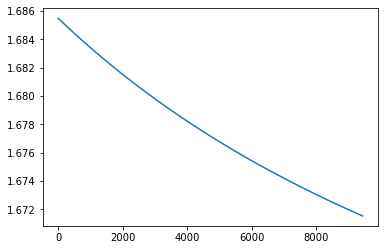

In [8]:
plt.plot(loss)

In [9]:
classifier.test(X_test, y_test)

Correct calssification = 4120/10000, Accuracy = 0.412000
